In [ ]:
!nvidia-smi

Fri Jun 27 13:21:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q accelerate
!pip install -q roboflow
!pip install -q torchmetrics
!pip install -q "albumentations>=1.4.5"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Imports

In [ ]:
import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
from google.colab import userdata
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

## Inference with pre-trained RT-DETR model

In [ ]:
# @title Load model

# CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
# CHECKPOINT = "PekingU/rtdetr_v2_r50vd"
# CHECKPOINT = "/content/drive/MyDrive/aml_finetune/checkpoint-741"
CHECKPOINT = "/content/drive/MyDrive/aml_finetune_rtdetrv2/checkpoint-624"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# @title Run inference

# URL = "https://media.istockphoto.com/id/2174134320/photo/team-of-young-asian-corporate-workers-taking-a-selfie-together-in-the-meeting-room.jpg?s=612x612&w=0&k=20&c=sATlB7NjMx3mSaOUO4ral8a90b6lqfNGvVW46YG1KoQ="
file_path = "/content/drive/MyDrive/dataset_processed_new/train/image_455.jpg"
# image = Image.open(requests.get(URL, stream=True).raw)
image = Image.open(file_path)
inputs = processor(image, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    outputs = model(**inputs)

w, h = image.size
results = processor.post_process_object_detection(
    outputs, target_sizes=[(h, w)], threshold=0.3)

In [ ]:
results[0]

{'scores': tensor([0.9400, 0.9073, 0.8996, 0.8905, 0.7614, 0.5102, 0.3759, 0.3547, 0.3434],
        device='cuda:0'),
 'labels': tensor([0, 1, 1, 1, 1, 0, 1, 0, 0], device='cuda:0'),
 'boxes': tensor([[ 370.3018,  491.8098,  608.4556,  844.4156],
         [  56.6275,  187.9524,  210.9232,  359.3491],
         [ 998.6661,  368.2386, 1102.5205,  469.0169],
         [ 797.2036,   36.0981,  890.0714,  151.5670],
         [ 411.3742,   54.9778,  506.4466,  171.1662],
         [ 371.1894,  487.4564,  610.4591,  845.4332],
         [ 414.7045,   54.6840,  505.5479,  171.0517],
         [ 370.5540,  487.1409,  611.0042,  844.7960],
         [ 370.9100,  486.1439,  609.1075,  842.8425]], device='cuda:0')}

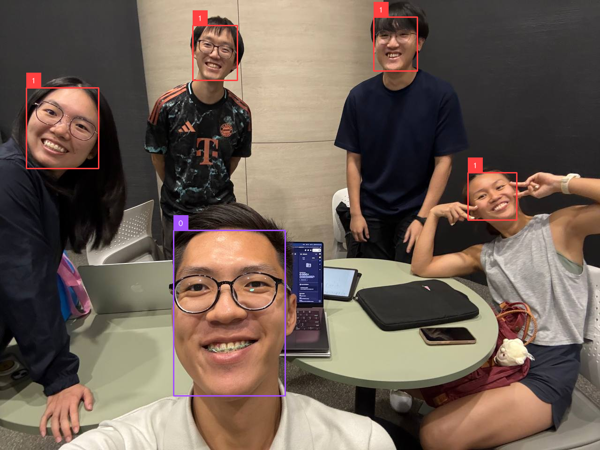

In [ ]:
# @title Display result with NMS

detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.3)
labels = [
    model.config.id2label[class_id]
    for class_id
    in detections.class_id
]

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels=labels)
annotated_image.thumbnail((600, 600))
annotated_image

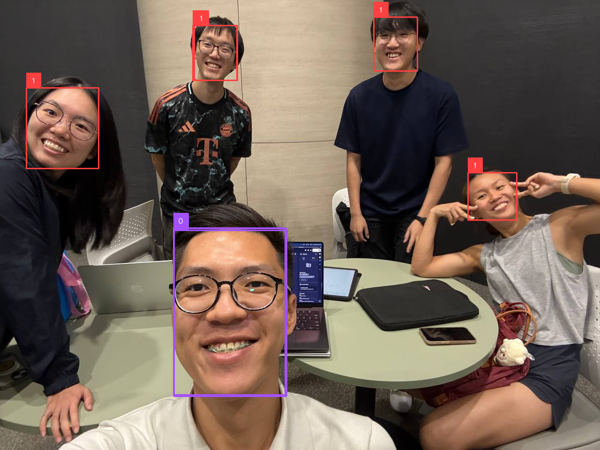

In [ ]:
# @title Display result without NMS

detections = sv.Detections.from_transformers(results[0])
labels = [
    model.config.id2label[class_id]
    for class_id
    in detections.class_id
]

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels=labels)
annotated_image.thumbnail((600, 600))
annotated_image

## Fine-tune RT-DETR on custom dataset

In [ ]:
from PIL import UnidentifiedImageError, Image
import random
from tqdm import tqdm
import shutil
import pandas as pd
import json

def convert_and_split_to_coco(
    base_path,
    output_path,
    split_ratio=(0.7, 0.2, 0.1),
    seed=42
):
    random.seed(seed)

    # Prepare
    image_files = sorted([
        f for f in os.listdir(base_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])

    base_names = [os.path.splitext(f)[0] for f in image_files]
    base_names = list(set(base_names))  # ensure unique
    random.shuffle(base_names)

    n = len(base_names)
    n_train = int(n * split_ratio[0])
    n_val = int(n * split_ratio[1])

    splits = {
        "train": base_names[:n_train],
        "valid": base_names[n_train:n_train + n_val],
        "test": base_names[n_train + n_val:]
    }

    annotation_id = 1
    global_image_id = 1  # unique across splits

    for split_name, split_files in splits.items():
        category_name_to_id = {}
        coco = {
            "images": [],
            "annotations": [],
            "categories": []
        }

        split_image_dir = os.path.join(output_path, split_name)
        os.makedirs(split_image_dir, exist_ok=True)
        annotation_output_path = os.path.join(split_image_dir, "_annotations.coco.json")

        for base_name in tqdm(split_files, desc=f"Processing {split_name}"):
            img_path = None
            for ext in ['jpg', 'jpeg', 'png', 'JPG', 'JPEG']:
                candidate = os.path.join(base_path, f"{base_name}.{ext}")
                if os.path.exists(candidate):
                    img_path = candidate
                    break
            if img_path is None:
                print(f"Image file for {base_name} not found.")
                continue

            # Check if image is readable
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image file is not broken
                    width, height = img.size
            except (UnidentifiedImageError, OSError) as e:
                print(f"Unreadable image skipped: {img_path} - {str(e)}")
                continue

            label_path_options = [
                os.path.join(base_path, "Labels", f"{base_name}.txt"),
                os.path.join(base_path, f"{base_name}.txt")
            ]

            label_path = None
            for path in label_path_options:
                if os.path.exists(path):
                    label_path = path
                    break

            if label_path is None:
                print(f"Label file not found for: {base_name}")
                continue

            shutil.copy(img_path, os.path.join(split_image_dir, os.path.basename(img_path)))

            # # Reopen image to get dimensions
            # with Image.open(img_path) as img:
            #     width, height = img.size

            coco["images"].append({
                "id": global_image_id,
                "file_name": os.path.basename(img_path),
                "width": width,
                "height": height
            })

            try:
                df = pd.read_csv(label_path)
            except:
                df = pd.read_csv(label_path, header=None, names=["box_id", "x1", "y1", "x2", "y2", "label"])

            for _, row in df.iterrows():
                x1, y1, x2, y2 = map(float, (row["x1"], row["y1"], row["x2"], row["y2"]))
                label = int(row["label"])
                width_box = x2 - x1
                height_box = y2 - y1
                area = width_box * height_box

                if label not in category_name_to_id:
                    category_name_to_id[label] = label
                    coco["categories"].append({
                        "id": label,
                        "name": str(label),
                        "supercategory": "none"
                    })

                coco["annotations"].append({
                    "id": annotation_id,
                    "image_id": global_image_id,
                    "category_id": label,
                    "bbox": [x1, y1, width_box, height_box],
                    "area": area,
                    "iscrowd": 0
                })
                annotation_id += 1

            global_image_id += 1

        # Save COCO JSON
        with open(annotation_output_path, "w") as f:
            json.dump(coco, f, indent=4)


In [ ]:
convert_and_split_to_coco(
    base_path="/content/drive/MyDrive/train",
    output_path="/content/drive/MyDrive/dataset_processed_new",
    split_ratio=(0.7, 0.2, 0.1)
)

Processing train:   1%|          | 3/333 [00:00<00:11, 29.91it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_092.jpg - cannot identify image file '/content/drive/MyDrive/train/image_092.jpg'
Unreadable image skipped: /content/drive/MyDrive/train/image_057.jpg - cannot identify image file '/content/drive/MyDrive/train/image_057.jpg'


Processing train:   7%|▋         | 22/333 [00:02<00:23, 13.33it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_447.jpg - cannot identify image file '/content/drive/MyDrive/train/image_447.jpg'


Processing train:  17%|█▋        | 55/333 [00:03<00:08, 32.30it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_446.jpg - cannot identify image file '/content/drive/MyDrive/train/image_446.jpg'


Processing train:  21%|██▏       | 71/333 [00:04<00:07, 36.26it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_242.jpg - cannot identify image file '/content/drive/MyDrive/train/image_242.jpg'


Processing train:  26%|██▋       | 88/333 [00:04<00:06, 37.42it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_049.jpg - cannot identify image file '/content/drive/MyDrive/train/image_049.jpg'


Processing train:  29%|██▉       | 97/333 [00:05<00:06, 37.04it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_093.jpg - cannot identify image file '/content/drive/MyDrive/train/image_093.jpg'


Processing train:  33%|███▎      | 110/333 [00:05<00:06, 36.22it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_065.jpg - cannot identify image file '/content/drive/MyDrive/train/image_065.jpg'
Unreadable image skipped: /content/drive/MyDrive/train/image_190.jpg - cannot identify image file '/content/drive/MyDrive/train/image_190.jpg'


Processing train:  44%|████▍     | 147/333 [00:06<00:04, 40.73it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_440.jpg - cannot identify image file '/content/drive/MyDrive/train/image_440.jpg'
Unreadable image skipped: /content/drive/MyDrive/train/image_430.jpg - cannot identify image file '/content/drive/MyDrive/train/image_430.jpg'


Processing train:  47%|████▋     | 158/333 [00:06<00:04, 42.43it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_062.jpg - cannot identify image file '/content/drive/MyDrive/train/image_062.jpg'


Processing train:  51%|█████     | 169/333 [00:06<00:03, 42.09it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_053.jpg - cannot identify image file '/content/drive/MyDrive/train/image_053.jpg'
Unreadable image skipped: /content/drive/MyDrive/train/image_191.jpg - cannot identify image file '/content/drive/MyDrive/train/image_191.jpg'
Unreadable image skipped: /content/drive/MyDrive/train/image_444.jpg - cannot identify image file '/content/drive/MyDrive/train/image_444.jpg'


Processing train:  59%|█████▊    | 195/333 [00:07<00:03, 42.57it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_245.jpg - cannot identify image file '/content/drive/MyDrive/train/image_245.jpg'


Processing train:  63%|██████▎   | 210/333 [00:07<00:03, 37.07it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_243.jpg - cannot identify image file '/content/drive/MyDrive/train/image_243.jpg'


Processing train:  67%|██████▋   | 224/333 [00:08<00:02, 40.47it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_064.jpg - cannot identify image file '/content/drive/MyDrive/train/image_064.jpg'
Unreadable image skipped: /content/drive/MyDrive/train/image_244.jpg - cannot identify image file '/content/drive/MyDrive/train/image_244.jpg'


Processing train:  81%|████████  | 270/333 [00:09<00:01, 37.08it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_192.jpg - cannot identify image file '/content/drive/MyDrive/train/image_192.jpg'
Unreadable image skipped: /content/drive/MyDrive/train/image_189.jpg - cannot identify image file '/content/drive/MyDrive/train/image_189.jpg'


Processing train:  87%|████████▋ | 290/333 [00:10<00:01, 35.02it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_066.jpg - cannot identify image file '/content/drive/MyDrive/train/image_066.jpg'


Processing train:  90%|█████████ | 301/333 [00:10<00:00, 41.64it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_188.jpg - cannot identify image file '/content/drive/MyDrive/train/image_188.jpg'
Unreadable image skipped: /content/drive/MyDrive/train/image_089.jpg - cannot identify image file '/content/drive/MyDrive/train/image_089.jpg'


Processing train:  97%|█████████▋| 324/333 [00:11<00:00, 39.44it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_003.JPG - cannot identify image file '/content/drive/MyDrive/train/image_003.JPG'
Unreadable image skipped: /content/drive/MyDrive/train/image_048.jpg - cannot identify image file '/content/drive/MyDrive/train/image_048.jpg'


Processing valid:  11%|█         | 10/95 [00:06<00:58,  1.45it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_453.jpg - cannot identify image file '/content/drive/MyDrive/train/image_453.jpg'


Processing valid:  47%|████▋     | 45/95 [00:22<00:08,  5.83it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_211.jpg - cannot identify image file '/content/drive/MyDrive/train/image_211.jpg'
Unreadable image skipped: /content/drive/MyDrive/train/image_004.JPG - cannot identify image file '/content/drive/MyDrive/train/image_004.JPG'


Processing valid:  82%|████████▏ | 78/95 [00:37<00:07,  2.26it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_449.jpg - cannot identify image file '/content/drive/MyDrive/train/image_449.jpg'


Processing test:   0%|          | 0/49 [00:00<?, ?it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_452.jpg - cannot identify image file '/content/drive/MyDrive/train/image_452.jpg'


Processing test:  27%|██▋       | 13/49 [00:03<00:08,  4.31it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_448.jpg - cannot identify image file '/content/drive/MyDrive/train/image_448.jpg'


Processing test:  35%|███▍      | 17/49 [00:05<00:12,  2.64it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_009.jpg - cannot identify image file '/content/drive/MyDrive/train/image_009.jpg'


Processing test:  39%|███▉      | 19/49 [00:06<00:14,  2.07it/s]

Unreadable image skipped: /content/drive/MyDrive/train/image_091.jpg - cannot identify image file '/content/drive/MyDrive/train/image_091.jpg'
Unreadable image skipped: /content/drive/MyDrive/train/image_432.jpg - cannot identify image file '/content/drive/MyDrive/train/image_432.jpg'
Unreadable image skipped: /content/drive/MyDrive/train/image_056.jpg - cannot identify image file '/content/drive/MyDrive/train/image_056.jpg'
Unreadable image skipped: /content/drive/MyDrive/train/image_445.jpg - cannot identify image file '/content/drive/MyDrive/train/image_445.jpg'


Processing test: 100%|██████████| 49/49 [00:18<00:00,  2.70it/s]


In [ ]:
import supervision as sv

dataset_path = "/content/drive/MyDrive/dataset_processed_new"

ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset_path}/train",
    annotations_path=f"{dataset_path}/train/_annotations.coco.json",
)

ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset_path}/valid",
    annotations_path=f"{dataset_path}/valid/_annotations.coco.json",
)

ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset_path}/test",
    annotations_path=f"{dataset_path}/test/_annotations.coco.json",
)

print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")
print(f"Number of test images: {len(ds_test)}")

Number of training images: 307
Number of validation images: 91
Number of test images: 42


Annotating: image_379.JPG
Annotating: image_076.jpeg
Annotating: image_098.jpg
Annotating: image_237.JPG
Annotating: image_333.jpg
Annotating: image_407.jpg
Annotating: image_458.png
Annotating: image_177.JPG
Annotating: image_464.png
Annotating: image_274.jpg
Annotating: image_298.jpg
Annotating: image_216.jpg
Annotating: image_054.JPG
Annotating: image_474.png
Annotating: image_497.png
Annotating: image_206.jpg
Annotating: image_391.JPG
Annotating: image_343.jpg
Annotating: image_181.jpg
Annotating: image_478.png
Annotating: image_466.png
Annotating: image_037.jpg
Annotating: image_267.jpg
Annotating: image_375.JPG
Annotating: image_462.png


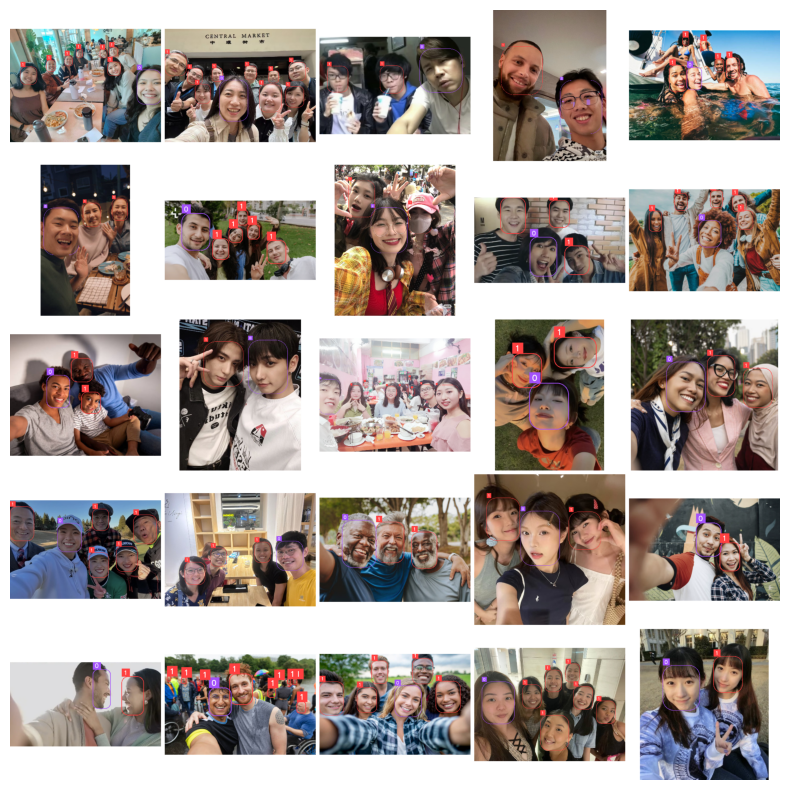

In [ ]:
# @title Display dataset sample
import os

GRID_SIZE = 5

def annotate(image, annotations, classes):
    labels = [
        classes[class_id]
        for class_id
        in annotations.class_id
    ]

    bounding_box_annotator = sv.RoundBoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    return annotated_image

annotated_images = []
for i in range(GRID_SIZE * GRID_SIZE):
    _, image, annotations = ds_train[i]

    if image is None:
        print(f"Image at {ds_train[i][0]} is None, skipping.")
        continue

    print(f"Annotating: {os.path.basename(ds_train[i][0])}")  # filename only

    annotated_image = annotate(image, annotations, ds_train.classes)
    annotated_images.append(annotated_image)

grid = sv.create_tiles(
    annotated_images,
    grid_size=(GRID_SIZE, GRID_SIZE),
    single_tile_size=(400, 400),
    tile_padding_color=sv.Color.WHITE,
    tile_margin_color=sv.Color.WHITE
)
sv.plot_image(grid, size=(10, 10))

### Preprocess the data

To finetune a model, you must preprocess the data you plan to use to match precisely the approach used for the pre-trained model. [AutoImageProcessor](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoImageProcessor) takes care of processing image data to create `pixel_values`, `pixel_mask`, and `labels` that a DETR model can train with. The image processor has some attributes that you won't have to worry about:

- `image_mean = [0.485, 0.456, 0.406 ]`
- `image_std = [0.229, 0.224, 0.225]`

These are the mean and standard deviation used to normalize images during the model pre-training. These values are crucial to replicate when doing inference or finetuning a pre-trained image model.

Instantiate the image processor from the same checkpoint as the model you want to finetune.

In [ ]:
IMAGE_SIZE = 480

processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)

Before passing the images to the `processor`, apply two preprocessing transformations to the dataset:

- Augmenting images
- Reformatting annotations to meet RT-DETR expectations

First, to make sure the model does not overfit on the training data, you can apply image augmentation with any data augmentation library. Here we use [Albumentations](https://albumentations.ai/docs/). This library ensures that transformations affect the image and update the bounding boxes accordingly.

In [ ]:
train_augmentation_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25
    ),
)

valid_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1
    ),
)

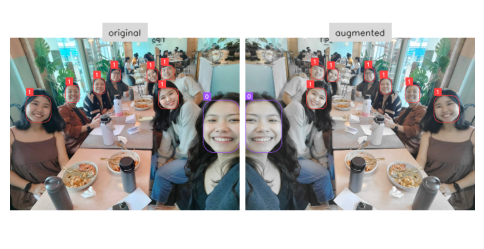

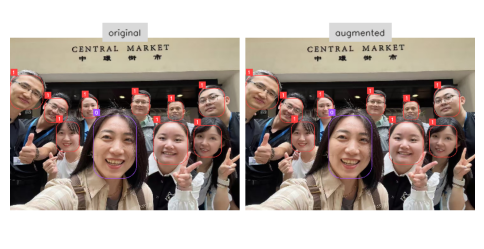

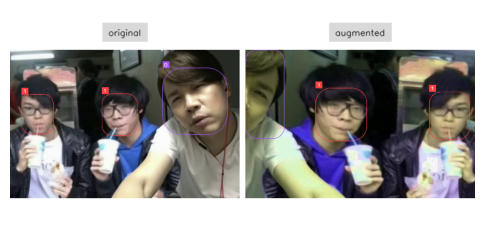

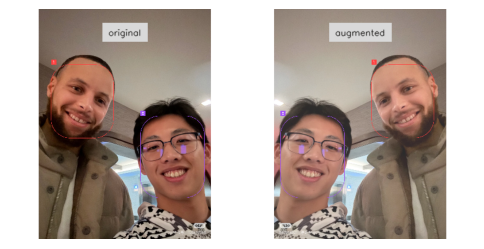

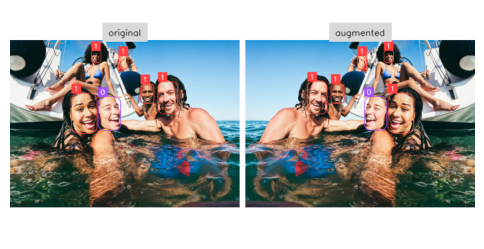

In [ ]:
# @title Visualize some augmented images

IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    _, image, annotations = ds_train[i]

    output = train_augmentation_and_transform(
        image=image,
        bboxes=annotations.xyxy,
        category=annotations.class_id
    )

    augmented_image = output["image"]
    augmented_annotations = replace(
        annotations,
        xyxy=np.array(output["bboxes"]),
        class_id=np.array(output["category"])
    )

    annotated_images = [
        annotate(image, annotations, ds_train.classes),
        annotate(augmented_image, augmented_annotations, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['original', 'augmented'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

The `processor` expects the annotations to be in the following format: `{'image_id': int, 'annotations': List[Dict]}`, where each dictionary is a COCO object annotation. Let's add a function to reformat annotations for a single example:

In [ ]:
class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset, processor, transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        # Convert image to RGB numpy array
        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result

Now you can combine the image and annotation transformations to use on a batch of examples:

In [ ]:
pytorch_dataset_train = PyTorchDetectionDataset(
    ds_train, processor, transform=train_augmentation_and_transform)
pytorch_dataset_valid = PyTorchDetectionDataset(
    ds_valid, processor, transform=valid_transform)
pytorch_dataset_test = PyTorchDetectionDataset(
    ds_test, processor, transform=valid_transform)

pytorch_dataset_train[15]

{'pixel_values': tensor([[[0.3882, 0.3961, 0.4039,  ..., 0.4275, 0.4275, 0.4235],
          [0.3922, 0.3961, 0.4039,  ..., 0.4275, 0.4275, 0.4275],
          [0.3922, 0.3961, 0.4039,  ..., 0.4314, 0.4314, 0.4314],
          ...,
          [0.3255, 0.3255, 0.3255,  ..., 0.0667, 0.0706, 0.0196],
          [0.3255, 0.3255, 0.3255,  ..., 0.0667, 0.0588, 0.0157],
          [0.3255, 0.3255, 0.3255,  ..., 0.0706, 0.0510, 0.0157]],
 
         [[0.5686, 0.5725, 0.5765,  ..., 0.6196, 0.6196, 0.6157],
          [0.5725, 0.5765, 0.5765,  ..., 0.6196, 0.6196, 0.6196],
          [0.5725, 0.5765, 0.5765,  ..., 0.6235, 0.6235, 0.6235],
          ...,
          [0.4157, 0.4157, 0.4157,  ..., 0.0588, 0.0588, 0.0157],
          [0.4157, 0.4157, 0.4157,  ..., 0.0627, 0.0510, 0.0118],
          [0.4157, 0.4157, 0.4157,  ..., 0.0706, 0.0431, 0.0078]],
 
         [[0.7647, 0.7647, 0.7686,  ..., 0.7882, 0.7882, 0.7843],
          [0.7647, 0.7686, 0.7686,  ..., 0.7882, 0.7882, 0.7882],
          [0.7608, 0.764

You have successfully augmented the images and prepared their annotations. In the final step, create a custom collate_fn to batch images together.

In [ ]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

## Preparing function to compute mAP

In [ ]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, (height, width) in zip(target_batch, image_size_batch):
                boxes = target["boxes"]
                boxes = sv.xcycwh_to_xyxy(boxes)
                boxes = boxes * np.array([width, height, width, height])
                boxes = torch.tensor(boxes)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.01, id2label=id2label)

## Training the detection model

You have done most of the heavy lifting in the previous sections, so now you are ready to train your model! The images in this dataset are still quite large, even after resizing. This means that finetuning this model will require at least one GPU.

Training involves the following steps:

- Load the model with [`AutoModelForObjectDetection`](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForObjectDetection) using the same checkpoint as in the preprocessing.
- Define your training hyperparameters in [`TrainingArguments`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
- Pass the training arguments to [`Trainer`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, image processor, and data collator.
- Call [`train()`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

When loading the model from the same checkpoint that you used for the preprocessing, remember to pass the `label2id` and `id2label` maps that you created earlier from the dataset's metadata. Additionally, we specify `ignore_mismatched_sizes=True` to replace the existing classification head with a new one.

In [ ]:
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
)

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decod

In the [`TrainingArguments`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) use `output_dir` to specify where to save your model, then configure hyperparameters as you see fit. For `num_train_epochs=10` training will take about 15 minutes in Google Colab T4 GPU, increase the number of epoch to get better results.

Important notes:

- Do not remove unused columns because this will drop the image column. Without the image column, you can't create `pixel_values`. For this reason, set `remove_unused_columns` to `False`.
- Set `eval_do_concat_batches=False` to get proper evaluation results. Images have different number of target boxes, if batches are concatenated we will not be able to determine which boxes belongs to particular image.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RTDetrV2ForObjectDetection(
  (model): RTDetrV2Model(
    (backbone): RTDetrV2ConvEncoder(
      (model): RTDetrResNetBackbone(
        (embedder): RTDetrResNetEmbeddings(
          (embedder): Sequential(
            (0): RTDetrResNetConvLayer(
              (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (normalization): RTDetrV2FrozenBatchNorm2d()
              (activation): ReLU()
            )
            (1): RTDetrResNetConvLayer(
              (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (normalization): RTDetrV2FrozenBatchNorm2d()
              (activation): ReLU()
            )
            (2): RTDetrResNetConvLayer(
              (convolution): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (normalization): RTDetrV2FrozenBatchNorm2d()
              (activation): ReLU()
            )
          )
          (pooler)

In [ ]:
import torch
print(torch.cuda.is_available())  # Should be True to use GPU
print(torch.cuda.get_device_name(0))  # GPU name if available

True
Tesla T4


In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/aml_finetune_rtdetrv2_260625",
    num_train_epochs=20,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=8,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
)

Finally, bring everything together, and call [`train()`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pytorch_dataset_train,
    eval_dataset=pytorch_dataset_valid,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

## Evaluate

In [ ]:
# @title Collect predictions

targets = []
predictions = []

for i in range(len(ds_test)):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    image = image.convert("RGB")
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)])

    detections = sv.Detections.from_transformers(results[0])

    targets.append(annotations)
    predictions.append(detections)

In [ ]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.3f}")
print(f"map50: {mean_average_precision.map50:.3f}")
print(f"map75: {mean_average_precision.map75:.3f}")

map50_95: 0.857
map50: 0.967
map75: 0.949


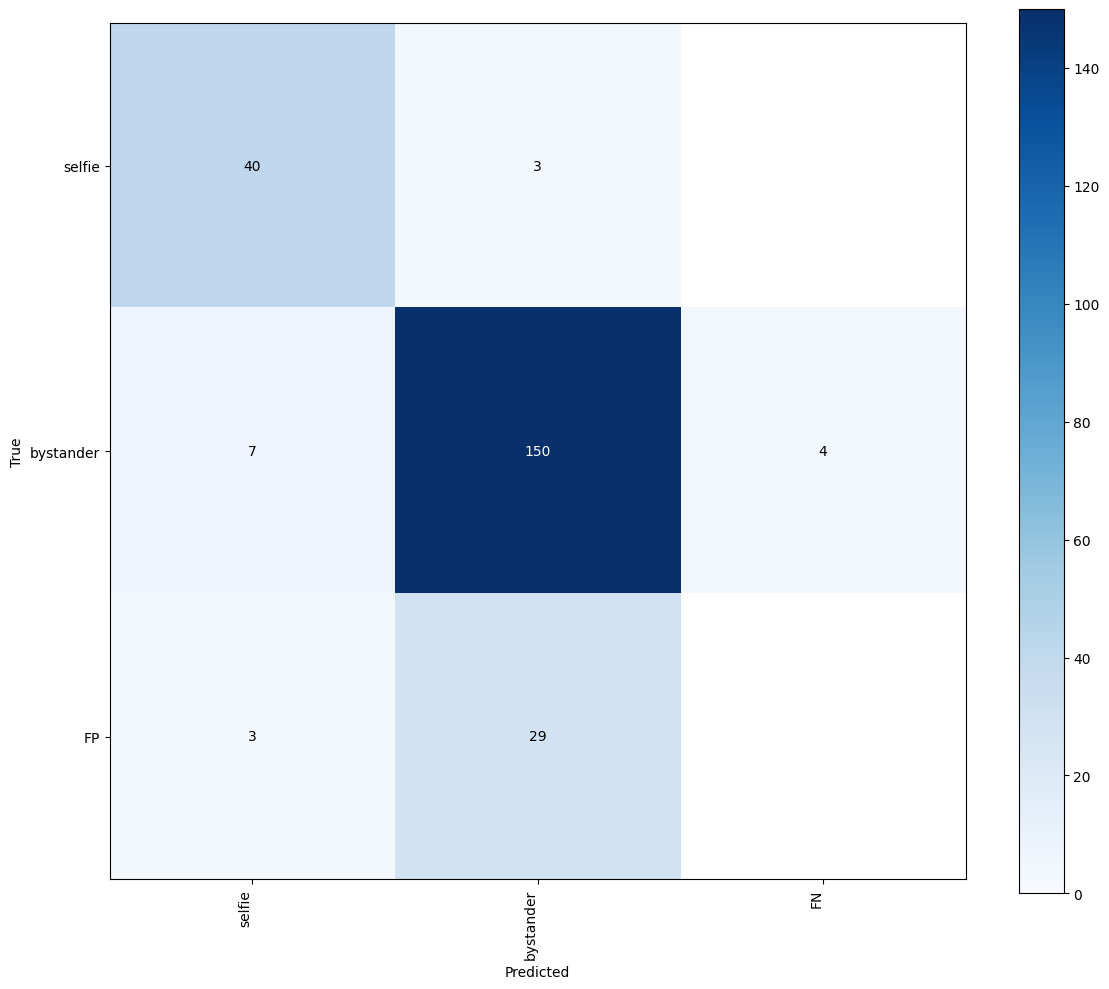

In [ ]:
# Updated class names
class_names = ["selfie", "bystander"]

# Create confusion matrix with custom class labels
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=class_names
)

# Plot the confusion matrix
_ = confusion_matrix.plot()


## Save fine-tuned model on hard drive

In [ ]:
model.save_pretrained("/content/rt-detr/")
processor.save_pretrained("/content/rt-detr/")

['/content/rt-detr/preprocessor_config.json']

## Inference with fine-tuned RT-DETR model

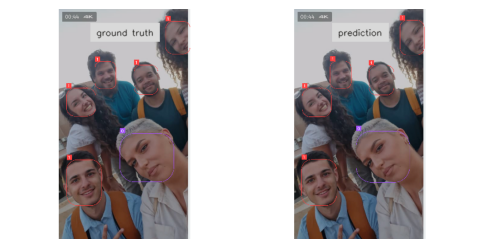

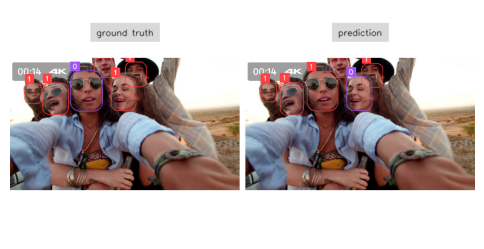

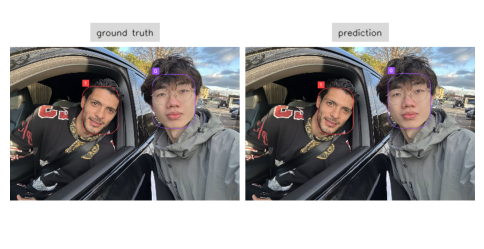

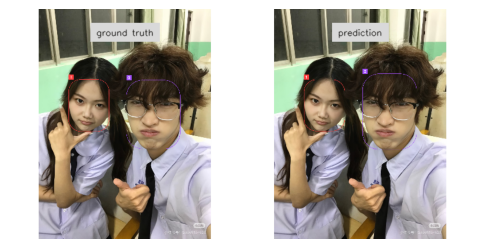

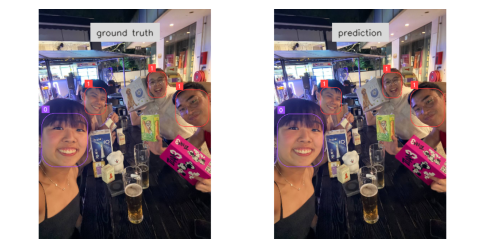

In [ ]:
IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)

    annotated_images = [
        annotate(sourece_image, annotations, ds_train.classes),
        annotate(sourece_image, detections, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['ground truth', 'prediction'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.3 MB/s eta 0:00:00


In [ ]:
def model_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
    }

In [ ]:
def compute_objective(metrics):
    return metrics["eval_map"]

In [ ]:
def model_init():
    model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
    )
    return model.to(device)

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=pytorch_dataset_train,
    eval_dataset=pytorch_dataset_valid,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

# trainer.train()

In [ ]:
best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=model_hp_space,
    compute_objective=compute_objective,
    n_trials=5,
    backend="optuna"
)
